# <center> Проект: Feature Engineering. Соревнование на Kaggle "Прогнозирование рейтинга отеля на Booking"

In [229]:
import numpy as np 
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
import statistics
import category_encoders as ce
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import spearmanr
from scipy.stats import ttest_ind
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')
from collections import Counter

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Евгений\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [230]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 113


# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
# !pip freeze > kaggle_requirements.txt
!pip freeze > local_venv_requirements.txt

##### Файлы для соревнования
* **hotels_train.csv** - набор данных для обучения
* **hotels_test.csv** - набор данных для оценки качества
* **submission.csv** - файл сабмишна в нужном формате

#### Признаки
* **hotel_address** - адрес отеля
* **review_date** - дата, когда рецензент разместил соответствующий отзыв.
* **average_score** - средний балл отеля, рассчитанный на основе последнего комментария за последний год
* **hotel_name** - название отеля
* **reviewer_nationality** - национальность рецензента
* **negative_review** - отрицательный отзыв, который рецензент дал отелю.
* **review_total_negative_word_counts** - общее количество слов в отрицательном отзыв
* **positive_review** - положительный отзыв, который рецензент дал отелю
* **review_total_positive_word_counts** - общее количество слов в положительном отзыве
* **reviewer_score** - оценка, которую рецензент поставил отелю на основе своего опыта
* **total_number_of_reviews_reviewer_has_given** - количество отзывов, которые рецензенты дали в прошлом
* **total_number_of_reviews** - общее количество действительных отзывов об отеле
* **tags** - теги, которые рецензент дал отелю.
* **days_since_review** - продолжительность между датой проверки и датой очистки
* **additional_number_of_scoring** - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* **lat** - широта отеля
* **lng** - долгота отеля

##### Метрика качества Результаты оцениваются по метрике MAPE ## Файл представления Для каждого **id** отеля в наборе тестовых данных вы должны предсказать рейтинг отеля для **reviewer_score** переменной. Файл должен содержать заголовок и иметь следующий формат: ``` reviewer_score,id 1,1 ```

#### Ознакамливаемся с данными

In [231]:
df_test = pd.read_csv('hotels_test.csv')
df_train = pd.read_csv('hotels_train.csv')
sample_submission = pd.read_csv('submission.csv')

In [232]:
df_test.head()


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644


In [233]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [234]:
df_train.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [235]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [236]:
sample_submission.head()

,reviewer_score,id
0,8.721,488440
1,7.051,274649
2,8.011,374688
3,9.733,404352
4,9.701,451596


In [237]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewer_score  128935 non-null  float64
 1   id              128935 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 2.0 MB


In [238]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [239]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 


#### 1. Избавляемся от пропусков

Видно , что есть пропуски в столбцах lat и lng их можно заменить на среднее значения 

In [240]:
values = {
    'lat': data['lat'].mean(),
    'lng': data['lng'].mean()
}
data = data.fillna(values)

#### 2. Работа с признаками

Из адресов отелей выделим  Страну Город

In [241]:
# Создадим список со всеми отелями
hotels_with_coor = data.groupby(['hotel_address']).count().reset_index().iloc[:,:3].set_index('hotel_address')

# Выделим страну из адресной строки
hotels_with_coor.loc[:,'country'] = \
hotels_with_coor.loc[:].apply(lambda x : 'United Kingdom' if x.name.split()[-1] == 'Kingdom' else x.name.split()[-1], axis = 1)

# Выделим город из адресной строки
hotels_with_coor.loc[:,'city'] = hotels_with_coor.apply(lambda x: ','.join(x.name.split(' ')[-2:-1]), axis = 1)
hotels_with_coor.city = hotels_with_coor.city.apply(lambda x: 'London' if x == 'United' else x)

# Выделим почтовый из адресной строки
hotels_with_coor.loc[:,'post_index'] = \
  hotels_with_coor.apply(lambda x: x.name.strip().split()[-4] if x.country in ('United Kingdom','Netherlands') \
    else x.name.strip().split()[-3], axis = 1)


# Создадим новый словарь с полученнми ранее данными
dict_hotel_extra = hotels_with_coor[['country','city','post_index']].\
  to_dict('dict')

# Создадим новые признаки в основном датафрейме
data['city'] = data.hotel_address.map(dict_hotel_extra['city'])
data['country'] = data.hotel_address.map(dict_hotel_extra['country'])





In [242]:
data['city'].value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64

In [243]:
data['country'].value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: country, dtype: int64

Получается так, что всего 6 стран и городов представленны, что в будущем можно преобразовать в числовое значение, так же видно что город и старна соостветсвуют, признак повторяет друг друга по этому можно оставить что-то одно, напрммер страну 

In [244]:
data = data.drop('city', axis=1)
data = data.drop('hotel_address', axis=1)

In [245]:
# 6 стран обработаем OneHotEncoder, создавая 6 новых бинарных признаков.
hotel_contry = data
encoder = ce.OneHotEncoder(cols=['country']) # Указываем столбец для кодирования.
hotel_contry = encoder.fit_transform(hotel_contry['country']) # Создаем датасет с новыми признаками
hotel_contry

,country_1,country_2,country_3,country_4,country_5,country_6
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,1,0,0,0,0,0
4,0,1,0,0,0,0
...,...,...,...,...,...,...
515733,0,0,0,1,0,0
515734,0,0,0,0,0,1
515735,0,0,0,1,0,0
515736,0,0,0,1,0,0


In [246]:
data= pd.concat([data, hotel_contry], axis=1) # Соединяем датасеты.
data = data.drop('country', axis=1) # Удаляем исходные признаки.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   review_date                                 515738 non-null  object 
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

#### 2.2 Работа с датой

In [247]:
# Создадим новые признаки из даты: год, месяц, день
data['review_date'] = pd.to_datetime(data['review_date'])
data['month']=pd.to_datetime(data['review_date']).dt.month
data['year']=pd.to_datetime(data['review_date']).dt.year
data['day']=pd.to_datetime(data['review_date']).dt.day


In [248]:
# Старый признак удаляем
data = data.drop('review_date', axis=1)

In [249]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 25 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   reviewer_nationality                        515738 non-null  object 
 4   negative_review                             515738 non-null  object 
 5   review_total_negative_word_counts           515738 non-null  int64  
 6   total_number_of_reviews                     515738 non-null  int64  
 7   positive_review                             515738 non-null  object 
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

##### 2.3 Тэги

In [250]:
tags = set()
tags_list = list()
for index, value in data['tags'].items():
        pre_tags = value
        pre_tags = pre_tags.replace('[', '').replace(']', '')
        pre_tags = pre_tags.replace("'", '')
        pre_tags = pre_tags.split(",")
        for i in pre_tags:
            tags.add(i.strip())
            tags_list.append(i.strip())
print(f'Всего уникальных тегов', {len(tags)})
print(f'Всего кол-во тегов', {len(tags_list)})

Всего уникальных тегов {2428}
Всего кол-во тегов {2356592}


In [251]:
# самые популярные таги добавим их к существующим признакам 
tags_series = pd.Series(
    data = tags_list,
    index = tags_list,
    name = 'tags_series'
)
print("Top 10 популярных тагов:")
print(tags_series.value_counts()[:10]) 

Top 10 популярных тагов:
Leisure trip                      417778
Submitted from a mobile device    307640
Couple                            252294
Stayed 1 night                    193645
Stayed 2 nights                   133937
Solo traveler                     108545
Stayed 3 nights                    95821
Business trip                      82939
Group                              65392
Family with young children         61015
Name: tags_series, dtype: int64


In [252]:
tags_df = pd.DataFrame(set(tags_series.value_counts()[:10].index), columns = ['tags'])


In [253]:
for tag in set(tags_df.tags):
    tag_name = str(tag)
    data[tag_name] =  data['tags'].apply(lambda x: 1 if tag_name in x else 0)

In [254]:
# Старый признак удаляем
data = data.drop('tags', axis=1)

In [255]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 34 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   reviewer_nationality                        515738 non-null  object 
 4   negative_review                             515738 non-null  object 
 5   review_total_negative_word_counts           515738 non-null  int64  
 6   total_number_of_reviews                     515738 non-null  int64  
 7   positive_review                             515738 non-null  object 
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

#### 2.4 Имя отеля

In [256]:
# в датасете более 1000 уникальных названий отелей, обработаем их LabelEncoder,
# а затем проскалируем значения,чтоб не преувеличивать вес высоких лейблов

data['hotel_name'] = LabelEncoder().fit_transform(data['hotel_name'])
temp_array = np.array(data['hotel_name']).reshape(data.shape[0],1)
scaler = preprocessing.StandardScaler()
data_num_scalar = scaler.fit_transform(temp_array)
data_num_text = pd.DataFrame(data_num_scalar, columns=['hotel_scalar_name'])
data_num_text

,hotel_scalar_name
0,-0.340735
1,1.502440
2,-1.621885
3,-0.068573
4,-0.294268
...,...
515733,-0.121678
515734,-1.464784
515735,-1.303257
515736,1.323212


In [257]:
# заменим hotel_name на скалированное значение
data = data.drop('hotel_name', axis=1) # Удаляем исходный признак
data = pd.concat([data, data_num_text], axis=1) # Присоединяем скалированный
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 34 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   reviewer_nationality                        515738 non-null  object 
 3   negative_review                             515738 non-null  object 
 4   review_total_negative_word_counts           515738 non-null  int64  
 5   total_number_of_reviews                     515738 non-null  int64  
 6   positive_review                             515738 non-null  object 
 7   review_total_positive_word_counts           515738 non-null  int64  
 8   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 9   days_since_review                           515738 non-null  object 
 

#### 2.5 Национальность

In [258]:
# Возьмем 10 самых частых национальностей, остальные пометим как other, обработаем labelEncoder
data['reviewer_nationality'].nunique()

227

In [259]:
pop_suburb= data['reviewer_nationality'].value_counts().nlargest(10).index
pop_suburb

Index([' United Kingdom ', ' United States of America ', ' Australia ',
       ' Ireland ', ' United Arab Emirates ', ' Saudi Arabia ',
       ' Netherlands ', ' Switzerland ', ' Germany ', ' Canada '],
      dtype='object')

In [260]:
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in pop_suburb else 'Other')
data['reviewer_nationality'].unique()

array([' United Kingdom ', 'Other', ' United States of America ',
       ' Netherlands ', ' Ireland ', ' Canada ', ' Australia ',
       ' Saudi Arabia ', ' Germany ', ' United Arab Emirates ',
       ' Switzerland '], dtype=object)

In [261]:
data['reviewer_nationality'] = LabelEncoder().fit_transform(data['reviewer_nationality'])
data.head(1)

,additional_number_of_scoring,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,...,Stayed 3 nights,Stayed 1 night,Family with young children,Solo traveler,Stayed 2 nights,Group,Couple,Business trip,Submitted from a mobile device,hotel_scalar_name
0,904,8.1,8,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,13 days,...,0,0,0,0,1,0,1,0,0,-0.340735


In [262]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 34 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   reviewer_nationality                        515738 non-null  int32  
 3   negative_review                             515738 non-null  object 
 4   review_total_negative_word_counts           515738 non-null  int64  
 5   total_number_of_reviews                     515738 non-null  int64  
 6   positive_review                             515738 non-null  object 
 7   review_total_positive_word_counts           515738 non-null  int64  
 8   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 9   days_since_review                           515738 non-null  object 
 

#### 2.6 Обработка отзывов

In [263]:
replace = {    
    'positive_review': ['no positive', 'nothing'],
    'negative_review': [
        'nothing really', 'no negative', 'nothing', 'n a', 'none', 'nothing at all', 'nothing to dislike',
        'everything was perfect', 'na', 'can t think of anything', 'nil','everything was great', 'absolutely nothing',
        'nothing to complain about', 'no', 'nothing not to like', 'nothing all good', 'no complaints', 'i liked everything', 
        'liked everything'
    ]
}

In [264]:
for key in replace:
    for value in replace[key]:
        data.loc[data[key].str.strip().str.lower()==value, key] = ''

In [265]:
data['review_total_positive_word_counts'] = data['positive_review'].apply(lambda s: len(s.strip().split(' ')))
data['review_total_negative_word_counts'] = data['negative_review'].apply(lambda s: len(s.strip().split(' ')))
data['review_total_negative_word_counts']

0         50
1          9
2          1
3          1
4          1
          ..
515733     1
515734     1
515735    10
515736     1
515737    18
Name: review_total_negative_word_counts, Length: 515738, dtype: int64

In [266]:
data['review_diff'] = data['positive_review'].str.len() - data['negative_review'].str.len()
data['review_diff']

0          75
1         -44
2          18
3         155
4          32
         ... 
515733     35
515734    436
515735     -5
515736     28
515737      9
Name: review_diff, Length: 515738, dtype: int64

In [267]:
polarity_columns = ['neg', 'neu', 'pos', 'compound']


In [268]:
analyzer = SentimentIntensityAnalyzer()


In [269]:
def get_polarity(row, analyzer):
    positive_counter = Counter(analyzer.polarity_scores(row['positive_review']))
    negative_counter = Counter(analyzer.polarity_scores(row['negative_review']))
    result_counter = positive_counter + negative_counter
    return [result_counter[col] for col in polarity_columns]

polarities = list(data.apply(get_polarity, analyzer=analyzer, axis=1))

data_polarity = pd.DataFrame(polarities, columns=polarity_columns)

In [270]:
data = pd.concat([data, data_polarity], axis=1)
data.drop(['positive_review', 'negative_review'], axis=1, inplace=True)
data.sample(2)

,additional_number_of_scoring,average_score,reviewer_nationality,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,...,Group,Couple,Business trip,Submitted from a mobile device,hotel_scalar_name,review_diff,neg,neu,pos,compound
110253,134,7.5,8,3,1266,19,1,467 day,48.850650,2.275087,...,0,1,0,1,-1.484698,89,0.000,1.506,0.494,0.9281
461393,471,7.9,8,29,2037,17,1,247 day,51.563476,-0.204276,...,1,0,0,1,-1.369638,-48,0.083,1.678,0.239,0.3039


In [271]:
# удалим признак days_since_review
data = data.drop('days_since_review', axis=1)

In [272]:
data.info(verbose = 37)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 36 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   reviewer_nationality                        515738 non-null  int32  
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   review_total_positive_word_counts           515738 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

#### 3. ОБУЧЕНИЕ МОДЕЛИ

In [273]:
# Теперь выделим тестовую часть
train_data = data.query('sample==1').drop(['sample'], axis=1)
test_data = data.query('sample==0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [274]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [275]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 35), (386803, 35), (386803, 34), (309442, 34), (77361, 34))

In [276]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели 

In [277]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [278]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished


In [279]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.8708044843562737


In [280]:
# оцениваем точность прогноза
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) # Этот коэффициент соответствует верхнему, если его вычесть из единицы.

print('MAPE:', mean_absolute_percentage_error(y_test, y_pred)) 

MAPE: 0.12449839229216406


In [281]:
metrics.mean_absolute_error(y_test, y_pred) + mean_absolute_percentage_error(y_test, y_pred)


0.9953028766484378

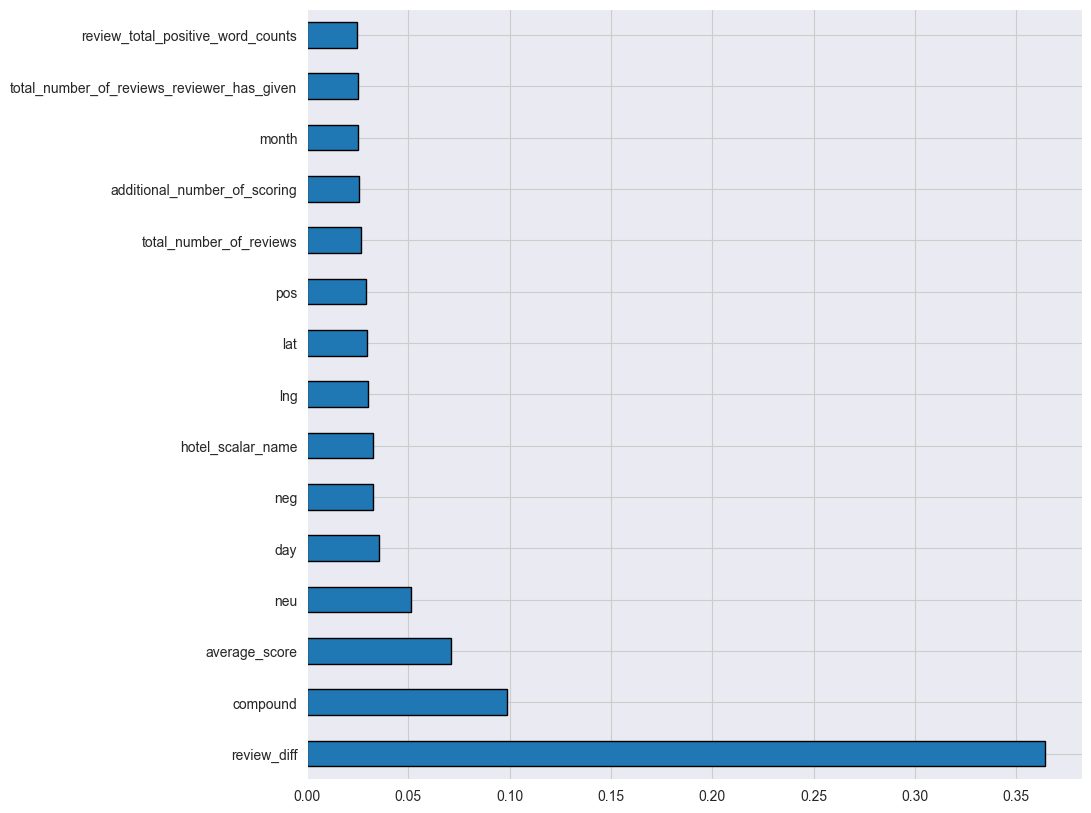

In [282]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

In [283]:
test_data.sample(10)


,additional_number_of_scoring,average_score,reviewer_nationality,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,reviewer_score,...,Group,Couple,Business trip,Submitted from a mobile device,hotel_scalar_name,review_diff,neg,neu,pos,compound
54712,904,8.1,10,92,16670,59,11,45.533137,9.171102,0.0,...,0,0,0,0,-0.340735,-172,0.154,1.477,0.369,0.9339
15231,102,8.5,10,8,1886,23,40,45.509997,9.173994,0.0,...,1,0,1,0,-1.641799,76,0.000,1.596,0.404,0.8807
121694,341,8.2,10,16,1496,3,3,51.520919,-0.156657,0.0,...,0,1,0,1,0.831994,-57,0.243,1.085,0.672,0.0826
22225,660,8.4,8,33,2902,36,1,51.493980,-0.143372,0.0,...,0,0,0,1,-1.057648,45,0.055,1.440,0.506,1.6910
7641,202,8.0,10,3,984,2,10,51.495818,-0.181396,0.0,...,1,0,1,1,-0.851867,-1,0.554,0.659,0.787,0.2149
112464,322,8.4,10,1,2140,15,4,51.512649,-0.180379,0.0,...,0,0,0,1,-1.548866,85,0.000,0.527,0.473,0.8945
31561,127,9.2,5,1,1073,78,12,48.868693,2.325211,0.0,...,0,0,0,0,-0.101764,378,0.069,0.748,0.183,0.8519
125292,334,8.5,2,1,2775,10,10,41.385889,2.168165,0.0,...,0,0,0,1,-0.055297,68,0.000,0.568,0.432,0.7264
5914,267,8.7,8,24,872,14,10,51.511011,-0.077125,0.0,...,0,1,0,0,-0.867356,-54,0.000,1.658,0.342,0.9861
113015,415,8.4,10,4,3340,3,12,41.384284,2.170709,0.0,...,0,0,1,0,1.002371,-1,0.499,1.501,0.000,0.0000


In [284]:
test_data = test_data.drop(['reviewer_score'], axis=1)


In [285]:
sample_submission

,reviewer_score,id
0,8.721,488440
1,7.051,274649
2,8.011,374688
3,9.733,404352
4,9.701,451596
...,...,...
128930,9.064,495812
128931,9.421,315577
128932,8.158,511968
128933,9.576,303386


In [286]:
predict_submission = model.predict(test_data)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.3s finished


In [287]:
predict_submission

array([8.589, 6.856, 8.043, ..., 8.291, 9.643, 7.255])

In [288]:
list(sample_submission)


['reviewer_score', 'id']

In [289]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.589,488440
1,6.856,274649
2,8.043,374688
3,9.755,404352
4,9.579,451596
5,9.119,302161
6,8.213,317079
7,7.986,13963
8,8.759,159785
9,7.857,195089
